# Working with Big Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## NumPy transformations

Many NumPy transformations, while fast, use one or more temporary arrays. Therefore, those transformations require more storage than the original array required.

An array of temperature values in Celsius is provided for you as celsius. Your job is to monitor memory consumption while applying NumPy vectorized operations. The data comes from The Weather Underground.

The function memory_footprint() has been provided for you to return the total amount of memory (in megabytes or MB) currently in use by your program. This function uses the psutil and os modules. You can find the function definition in the course appendix.

In [3]:
celsius = np.array([-3.88888889, -3.33333333, -3.33333333,  0.55555556,
       -0.55555556,  0.        ])

In [4]:
import psutil, os
def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss     
    return (mem / 1024 ** 2)

In [5]:
# Print the size in MB of the celsius array
print(celsius.nbytes / 1024**2)

# Call memory_footprint(): before
before = memory_footprint()

# Convert celsius by multiplying by 9/5 and adding 32: fahrenheit
fahrenheit = celsius * 9/5 + 32

# Call memory_footprint(): after
after = memory_footprint()

# Print the difference between after and before
print(after - before)

4.57763671875e-05
0.0


## Filtering WDI data in chunks

Using the World Bank's World Development Indicators (or WDI) dataset, you're going to plot the percentage of the population of Australia in urban centers since 1980.

Your job is to loop over chunks of the WDI dataset; from each chunk, you will filter out rows describing Australia's "percent urban population." You'll then concatenate the filtered chunks and plot the results. pandas has been pre-imported for you as pd.

In [6]:
# Create empty list: dfs
dfs = []

# Loop over 'WDI.csv'
for chunk in pd.read_csv('WDI.csv', chunksize=1000):
    # Create the first Series
    is_urban = chunk['Indicator Name']=='Urban population (% of total)'
    # Create the second Series
    is_AUS = chunk['Country Code']=='AUS'

    # Create the filtered chunk: filtered
    filtered = chunk.loc[is_urban & is_AUS]

    # Append the filtered chunk to the list dfs
    dfs.append(filtered)

## Concatenating & plotting WDI data

In the previous exercise, you read a large CSV file by chunks, performed boolean filtering on each chunk, and stored each filtered chunk in a list. Before filtering, each chunk contained up to 1000 rows. However, after filtering, some of the filtered chunks had no rows. You'll now use len() to determine the number of chunks and the actual number of rows that the filter retains.

Your job is to use pd.concat() to make a single DataFrame from the list dfs; this list is provided for you. The function pd.concat() will take the list of DataFrames and concatenate them into a new DataFrame object. Finally, you will plot the results. The modules matplotlib.pyplot and pandas have been imported for you with standard aliases (plt and pd respectively).

92
36


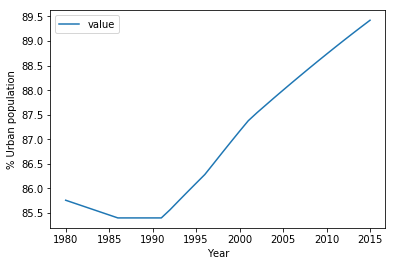

In [7]:
# Print length of list dfs
print(len(dfs))

# Apply pd.concat to dfs: df
df = pd.concat(dfs)

# Print length of DataFrame df
print(len(df))

# Call df.plot.line with x='Year' and y='value'
df.plot.line(x='Year', y='value')
plt.ylabel('% Urban population')

# Call plt.show()
plt.show()

## Computing percentage of delayed flights

Multiple CSV files of flight information have been provided from the Bureau of Transportation Statistics. Each file contains one month of information in 2016.

Your first job is to build a function to compute the percentage of delayed flights given a DataFrame of flight information. Your function will take a single DataFrame as input and compute the percentage of its rows in which the 'DEP_DELAY' value is greater than zero.

In [8]:
# Define function with single input called df: pct_delayed
def pct_delayed(df):
    # Compute number of delayed flights: n_delayed
    n_delayed = (df['DEP_DELAY']>0).sum()
    # Return percentage of delayed flights
    return n_delayed  * 100 / len(df)

## Generating & plotting delayed flights

Now that you have a function to compute flight delays, you'll apply it with a generator to analyze the percentage of delayed flights for each month of 2016.

You'll create a generator expression to loop over the provided list filenames and return a sequence of DataFrames. For each DataFrame, you'll then apply the function pct_delayed() (provided for you) within a list comprehension. Finally, you'll plot the results (matplotlib and pandas have been imported for you).

Warning: This exercise requires several seconds to execute.

In [12]:
filenames = ['flightdelays-2016-1.csv',
 'flightdelays-2016-2.csv',
 'flightdelays-2016-3.csv',
 'flightdelays-2016-4.csv',
 'flightdelays-2016-5.csv',]

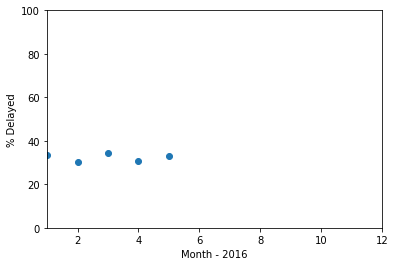

In [14]:
# Define the generator: dataframes
dataframes = (pd.read_csv(file) for file in filenames)

# Create the list comprehension: monthly_delayed
monthly_delayed = [pct_delayed(df) for df in dataframes]

# Create the plot
x = range(1,6)
plt.plot(x, monthly_delayed, marker='o', linewidth=0)
plt.ylabel('% Delayed')
plt.xlabel('Month - 2016')
plt.xlim((1,12))
plt.ylim((0,100))
plt.show()

## Building a pipeline with delayed

If we use dask.delayed, we don't need to use generators; the dask scheduler will manage memory usage. In this version of the flight delay analysis, you'll compute the total yearly percentage of delayed flights.

Along with pandas, the decorator function delayed has been imported for you from dask, and the following decorated function, which calls pd.read_csv() on a single file, has been created for you:

    @delayed
    def read_one(filename):
        return pd.read_csv(filename)

Your job is to define three decorated functions to complete the pipeline: a function to total the number of flights, a function to count the number of delayed flights, and a function to aggregate the results.

In [17]:
from dask import delayed

@delayed
def read_one(filename):
    return pd.read_csv(filename)


In [18]:
# Define count_flights
@delayed
def count_flights(df):
    return len(df)

# Define count_delayed
@delayed
def count_delayed(df):
    return (df['DEP_DELAY']>0).sum()

# Define pct_delayed
@delayed
def pct_delayed(n_delayed, n_flights):
    return 100 * sum(n_delayed) / sum(n_flights)

## Computing pipelined results

Now that the dask.delayed functions are defined, we can use them to construct the pipeline of delayed tasks.

Your job is to loop over the file names, store the temporary information in lists, and aggregate the final result. Two empty lists, n_delayed, and n_flights, have been created for you.

The distinction here is that we are working with dask.delayed functions and objects, not real, computed values. The computation will only be executed when you call .compute() on the final result (by contrast with earlier exercises).

Warning: The expected execution time of this exercise is several seconds.

In [20]:
n_delayed = []
n_flights = []

# Loop over the provided filenames list and call read_one: df
for file in filenames:
    df = read_one(file)

    # Append to n_delayed and n_flights
    n_delayed.append(count_delayed(df))
    n_flights.append(count_flights(df))

# Call pct_delayed with n_delayed and n_flights: result
result = pct_delayed(n_delayed, n_flights)

# Print the output of result.compute()
print(result.compute())

32.406252934201824


# Working with Dask Arrays

## Inspecting a Dask array

A dask.array called energy is provided for you. The array energy contains electricity load in kWh in Texas sampled every 15 minutes for the year 2000. This dataset was provided by ERCOT.

Your job is to determine the correct shape of the array energy and the total electricity (in kWh) consumed by Texas for the year 2000 (i.e., the sum of the electricity load). Remember to leverage both the .sum() and .compute() methods.

## Chunking a NumPy array

A NumPy array has been provided for you as energy. This is the electricity load in kWh for the state of Texas sampled every 15 minutes over the year 2000 (that's about 35 thousand samples).

Your job is to convert the NumPy array into a dask.array; the dask.array should have chunks whose sizes are 1/4 of the number of elements of the array energy. You will then inspect the chunk sizes of the Dask array. Finally, you'll compute the mean electricity load in kWh in two ways (using the dask.array and using the NumPy array) to compare the results.

In [24]:
energy = np.array([5282.56, 5267.62, 5252.65, 5136.65, 5138.3 , 5139.89])

In [27]:
import dask.array as da

# Call da.from_array():  energy_dask
energy_dask = da.from_array(energy, chunks=energy.shape[0]//4)

# Print energy_dask.chunks
print(energy_dask.chunks)

# Print Dask array average and then NumPy array average
print(energy_dask.mean().compute())
print(energy.mean())

((1, 1, 1, 1, 1, 1),)
5202.945
5202.945


## Timing Dask array computations

Your job now is to create two Dask arrays from energy using different chunksizes. You'll then measure the time required (in milliseconds) to compute the standard deviation of each Dask array.

The NumPy array energy is provided as before and the module dask.array is imported for you as da.

In [28]:
# Import time
import time

# Call da.from_array() with arr: energy_dask4
energy_dask4 = da.from_array(energy, chunks=energy.shape[0]//4)

# Print the time to compute standard deviation
t_start = time.time()
std_4 = energy_dask4.std().compute()
t_end = time.time()
print((t_end - t_start) * 1.0e3)

8.97216796875


## Subtracting & broadcasting

Now that you're comfortable with broadcasting rules, you're going to practice using the .reshape() method together with broadcasting.

The one-dimensional array load_2001 holds the total electricity load for the state of Texas sampled every 15 minutes for the entire year 2001 (35040 samples in total). The one-dimensional array load_recent holds the corresponding data sampled for each of the years 2013 through 2015 (i.e., 105120 samples consisting of the samples from 2013, 2014, & 2015 in sequence). None of these years are leap years, so each year has 365 days. Observe also that there are 96 intervals of duration 15 minutes in each day.

Your job is to compute the differences of the samples in the years 2013 to 2015 each from the corresponding samples of 2001.

In [34]:
load_2001 = np.array([4247.18, 4256.01, 4264.82, 5134.57, 5117.64, 5100.78])
load_recent = np.array([4014.076, 4009.591, 4006.342, 4408.787, 4386.031, 4361.135])

In [35]:
# Reshape load_recent to three dimensions: load_recent_3d
load_recent_3d = load_recent.reshape((3,365,96))

ValueError: cannot reshape array of size 6 into shape (3,365,96)

## Computing aggregations

You'll now compute summary statistics by aggregating NumPy arrays across various dimensions (in this case, giving trends in electricity usage).

The load_recent_3d NumPy array from the last exercise is provided for you. It contains the electricity load (in kWh) sampled every 15 minutes from the start of 2013 to the end of 2015. The possible index values of the three-dimensional array correspond to year (from 0 to 2), day (from 0 to 364), and 15-minute interval (from 0 to 95); remember, NumPy arrays are indexed from zero. Thus, load_recent_3d[0,1,2] is the electricity load consumed on January 2nd, 2013 from 00:30:00 AM to 00:45:00 AM.

In [36]:
# Print mean value of load_recent_3d
print(load_recent_3d.mean())

NameError: name 'load_recent_3d' is not defined

## Reading the data

For this exercise, the monthly average maximum temperature (degrees Celsius) data on a 10km grid has been downloaded from NOAA for the continental US.

The data is stored in separate HDF5 files from 2008 to 2011. Your job is to use h5py to connect to the datasets and prepare a list of Dask arrays where each element is one year of data. The list of filenames is provided for you as filenames. The chunksizes have been chosen to optimize reading data from disk.

For this exercise you'll utilize a list comprehension to quickly iterate through the filenames list and form a new list of h5py file handles and again to make a list of Dask arrays.

In [37]:
# Import h5py and dask.array
import h5py
import dask.array as da

# List comprehension to read each file: dsets
dsets = [h5py.File(f)['/tmax'] for f in filenames]

# List comprehension to make dask arrays: monthly
monthly = [da.from_array(d, chunks=(1,444,922)) for d in dsets]

OSError: Unable to create file (unable to open file: name = 'flightdelays-2016-1.csv', errno = 17, error message = 'File exists', flags = 15, o_flags = 502)

## Stacking data & reading climatology

Now that we have a list of Dask arrays, your job is to call da.stack() to make a single Dask array where month and year are in separate dimensions. You'll also read the climatology data set, which is the monthly average max temperature again from 1970 to 2000.

In [38]:
# Stack with the list of dask arrays: by_year
by_year = da.stack(monthly, axis=0)

NameError: name 'monthly' is not defined

## Transforming, aggregating, and plotting

Now that we have two Dask arrays, one for the monthly average temperature from 2008 to 2011 and one for the 30-year climatology average we can compute the deviation from the climatology by taking a difference. The climatology data will be broadcast into each each year of the outer dimension of by_year.

Your job is to compute the difference, convert it to Fahrenheit, and take the average over the latitude and longitude dimensions. For this you'll use the da.nanmean() function, which ignores missing values. Finally, you'll make a plot of the monthly average deviation each year for January, August, and December.

The arrays you made in the last exercise are provided for you and the pyplot module from matplotlib has been imported as plt.

In [39]:
# Compute the difference: diff
diff = (by_year - climatology) * 9/5
# Compute the average over last two axes: avg
avg = da.nanmean(diff, axis=(-1,-2)).compute()
# Plot the slices [:,0], [:,7], and [:11] against the x values
x = range(2008,2012)
f, ax = plt.subplots()
ax.plot(x,avg[:,0], label='Jan')
ax.plot(x,avg[:,7], label='Aug')
ax.plot(x,avg[:,11], label='Dec')
ax.axhline(0, color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Difference (degrees Fahrenheit)')
ax.legend(loc=0)
plt.show()

NameError: name 'by_year' is not defined

# Working with Dask DataFrames

## Inspecting a large DataFrame

A Dask DataFrame is provided for you called df. This DataFrame connects to the World Development Indicators data set you worked with earlier.

Your job is to inspect this Dask DataFrame using methods and correctly identify the number of columns, the number of rows, and the number of unique countries from either the Country Name or Country Code columns. You can use methods you are already familiar with such as .describe() and .info(). Remember to also use .compute(), since df is a Dask (and not pandas) DataFrame.

## Building a pipeline of delayed tasks

For this exercise, you'll use a Dask DataFrame to read and process the World Bank's World Development Indicators.

Your job is to filter the DataFrame for the 'East Asia & Pacific' region and measurements of the percent population exposed to toxic air pollution. The output of this effort is a delayed Dask DataFrame; you'll compute the result in the next exercise.

The CSV file 'WDI.csv' has been truncated to reduce execution time.

In [52]:
import dask.dataframe as dd

# Read from 'WDI.csv': df
df = dd.read_csv('WDI.csv').compute()

# Boolean series where 'Indicator Code' is 'EN.ATM.PM25.MC.ZS': toxins
toxins = df['Indicator Code'] == 'AG.PRD.CROP.XD'
# Boolean series where 'Region' is 'East Asia & Pacific': region
region = df['Region'] == 'East Asia & Pacific'

# Filter the DataFrame using toxins & region: filtered
filtered = df.loc[toxins & region]

,Country Name,Country Code,Indicator Name,Indicator Code,Year,value,Region
7,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1980,45.96,East Asia & Pacific
28,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1981,45.67,East Asia & Pacific
49,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1982,45.77,East Asia & Pacific
70,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1983,44.43,East Asia & Pacific
91,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1984,42.17,East Asia & Pacific
112,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1985,40.72,East Asia & Pacific
133,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1986,41.72,East Asia & Pacific
154,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1987,38.44,East Asia & Pacific
175,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1988,38.38,East Asia & Pacific
196,American Samoa,ASM,Crop production index (2004-2006 = 100),AG.PRD.CROP.XD,1989,38.19,East Asia & Pacific


## Grouping & aggregating by year

The filtered Dask DataFrame from the previous exercise has been provided for you as filtered. In this exercise you're going to plot the average percent of the population exposed to air pollution in the East Asia & Pacific region from 2010 to 2015.

Your job is to use .groupby() to collect all of the individual country values by the 'Year' column and aggregate with the mean() function. You'll then call .compute() to perform the computation in parallel, and finally plot the results.

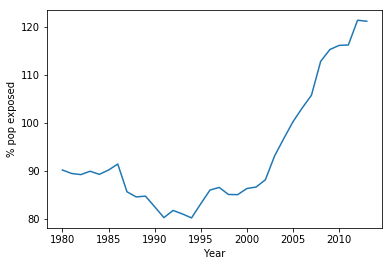

In [54]:
# Grouby filtered by the 'Year' column: yearly
yearly = filtered.groupby('Year')

# Calculate the mean of yearly: yearly_mean
yearly_mean = yearly.mean()

# Call .compute() to perform the computation: result
result = yearly_mean

# Plot the 'value' column with .plot.line()
result['value'].plot.line()
plt.ylabel('% pop exposed')
plt.show()


## Preparing the pipeline

Since pandas and Dask share the same API, we can write functions that work for both libraries. Your job here is to write a function that takes a DataFrame as input, performs Boolean filtering, groupby, and returns the result.

In the next exercise you'll apply this function on Dask and pandas DataFrames and compare the time it takes to complete.

In [55]:
# Define a function with df as input: by_region
def by_region(df):

    # Create the toxins array
    toxins = df['Indicator Code'] == 'EN.ATM.PM25.MC.ZS'

    # Create the y2015 array
    y2015 = df['Indicator Code'] == 2015

    # Filter the DataFrame and group by the 'Region' column
    regions = df.loc[toxins & y2015].groupby('Region')

    # Return the mean of the 'value' column of regions
    return regions['value'].mean()


## Comparing Dask & pandas execution times

The function you created in the last exercise can be used with either Dask or Pandas DataFrames. The only difference is that after the function is run on a Dask DataFrame, .compute() must be called on the result to perform the computation.

Your job is to run the by_region function separately on a Pandas DataFrame and a Dask DataFrame read from the same CSV file. To help understand how much time is taken when reading the file you'll compare the execution of the function with the Dask DataFrame to the Pandas DataFrame where the time taken to call pd.read_csv is included or ignored.

In [56]:
# Call time.time()
t0 = time.time()

# Read 'WDI.csv' into df
df = pd.read_csv('WDI.csv')

# Group df by region: result
result = by_region(df)

# Call time.time()
t1 = time.time()

# Print the execution time
print((t1-t0)*1000)

183.51149559020996


## Reading & cleaning files

Here you'll be working with a subset of the NYC Taxi Trip data. The first step is to use the Dask dd.read_csv() function to read multiple files at once. Dask will automatically concatenate the contents of the files into a single DataFrame. Notice that you'll use the option assume_missing=True in the call to dd.read_csv() to suppress warning messages.

Your job is to use a glob pattern containing the * character to read all of the CSV files from the taxi/ subdirectory into a single Dask DataFrame. You'll then construct a new column called 'tip_fraction' using the 'tip_amount' and 'total_amount' columns. The 'total_amount' is the sum of the fare, other fees, and the tip_amount.

In [58]:
# Read all .csv files: df
df = dd.read_csv('taxi/*.csv', assume_missing=True)

# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

## Filtering & grouping data

You have the Dask dataframe df prepared using multiple CSV files from the last exercise. It contains a subset of the 2015 yellow taxi ride data from New York City with some additional columns from preprocessing. Remember, none of the files have actually been loaded, nor has any computation been done to construct the new columns.

Your task now is to build a pipeline of computations to compute the hourly average tip fraction for each hour of the day across the entire year of data. You'll have to filter for payments of type 1 (credit card transactions) from the 'payment_type' column, group transactions using the 'hour' column, and finally aggregate the mean from the 'tip_fraction' column.

In [59]:
# Filter rows where payment_type == 1: credit
credit = df.loc[df['payment_type']==1]

# Group by 'hour' column: hourly
hourly = credit.groupby('hour')

# Aggregate mean 'tip_fraction' and print its data type
result = hourly['tip_fraction'].mean()
print(type(result))

<class 'dask.dataframe.core.Series'>


## Computing & plotting

Now that you've got the entire delayed pipeline prepared it's time compute and plot the result. Matplotlib has been imported for you as plt.

Warning: The execution of of this exercise is expected to be several seconds.

<class 'pandas.core.series.Series'>


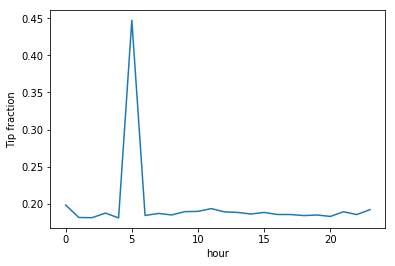

In [60]:
# Perform the computation
tip_frac = result.compute()

# Print the type of tip_frac
print(type(tip_frac))

# Generate a line plot using .plot.line()
tip_frac.plot.line()
plt.ylabel('Tip fraction')
plt.show()

# Working with Dask Bags for Unstructured Data

## Inspecting Dask Bags

A Dask bag is provided for you as bag. It contains a number of Python objects. Your job is to inspect the bag to determine the number of elements in the bag, which may be different from the total number of Python objects stored in the bag and whether all of them are true.

Note: In this chapter the Distributed Scheduler is being used. Review the Dask scheduler choices for more information.

## Reading & counting

The sotu/ directory contains text files for each of the 45 US Presidents as of 2017. These text files contain the State of the Union addresses delivered by each president. The texts of the speeches were obtained from the American Presidency Project.

The entire speech for each State of the Union address is on a single line in each text file; that is, individual addresses are separated by '\n'. For example, the 33rd US president Truman delivered 9 State of the Union speeches, so the file sotu/33Truman.txt has 9 lines). Distinct files, then have distinct numbers of lines according to the number of State of the Union addresses each president delivered during their presidency.

In [64]:
import glob
import dask.bag as db

# Glob filenames matching 'sotu/*.txt' and sort
filenames = glob.glob('sotu/*.txt')
filenames = sorted(filenames)

# Load filenames as Dask bag with db.read_text(): speeches
speeches = db.read_text(filenames)

# Print number of speeches with .count()
print(speeches.count().compute())

237


## Taking one element

Let's start using data from the Dask bag speeches of State of the Union addresses. For large datasets, the .take() method is useful for inspecting data & data types while processing dask bags. The value returned by .take(n) is a tuple of the first n elements of the dask.bag.

The speeches bag from the previous exercise is provided for you. Your task is to extract the first element of the bag using .take(), to determine its datatype, and to print the words of the first speech.

In [65]:
# Call .take(1): one_element
one_element = speeches.take(1)

# Extract first element of one_element: first_speech
first_speech = one_element[0]

# Print type of first_speech and first 60 characters
print(type(first_speech))
print(first_speech[:60])

<class 'str'>
 Fellow-Citizens of the Senate and House of Representatives:


## Splitting by word & count

Using the speeches bag from earlier exercises let's examine some statistics about the State of the Union addresses.

Your job is to split each speech into a list of words using a single space ' ' as the separator. At this point the Dask Bag can be considered a list-of-lists. You'll then map the len() function over each of the inner lists to compute the number of words in each speech and then compute the mean() of the lengths to get the average word count.

In [66]:
# Call .str.split(' ') from speeches and assign it to by_word
by_word = speeches.str.split(' ')

# Map the len function over by_word and compute its mean
n_words = by_word.map(len)
avg_words = n_words.mean()

# Print the type of avg_words and value of avg_words.compute()
print(type(avg_words))
print(avg_words.compute())

<class 'dask.bag.core.Item'>
8239.084388185654


## Filtering on a phrase

In this exercise you'll make use of the filter function to take the 226 State of the Union addresses and find the addresses where the phrase health care was mentioned. In order to do this you must first standardize the capitalization of all words in each speech.

Your job is to convert all speeches to lower case and write a lambda function that returns true if the substring 'health care' is contained in each speech and filter with it. Finally, you'll count the number of speeches retained by the filter.

The speeches Dask Bag is provided for you.

In [67]:
# Convert speeches to lower case: lower
lower = speeches.str.lower()

# Filter lower for the presence of 'health care': health
health = lower.filter(lambda s:'health care' in s)

# Count the number of entries : n_health
n_health = health.count()

# Compute and print the value of n_health
print(n_health.compute())

47


## Loading & mapping from JSON

A collection of JSON files for Congressional bills have been downloaded from GovTrack.us. All bills presented during each congressional session from 1973 - 2017 are provided in separate files.

Your job is to read the bills*.json files into a Dask Bag. You'll then use the JSON module to map the text of each file into Python dictionaries. You'll then inspect the first element of the Dask Bag.

In [69]:
# Call db.read_text with congress/bills*.json: bills_text
bills_text = db.read_text('congress/bills*.json')

In [70]:
# Call db.read_text with congress/bills*.json: bills_text
bills_text = db.read_text('congress/bills*.json')

# Map the json.loads function over all elements: bills_dicts
bills_dicts = bills_text.map(json.loads)

In [71]:
# Call db.read_text with congress/bills*.json: bills_text
bills_text = db.read_text('congress/bills*.json')

# Map the json.loads function over all elements: bills_dicts
bills_dicts = bills_text.map(json.loads)

# Extract the first element with .take(1) and index to the first position: first_bill
first_bill = bills_dicts.take(1)[0]

In [72]:
# Call db.read_text with congress/bills*.json: bills_text
bills_text = db.read_text('congress/bills*.json')

# Map the json.loads function over all elements: bills_dicts
bills_dicts = bills_text.map(json.loads)

# Extract the first element with .take(1) and index to the first position: first_bill
first_bill = bills_dicts.take(1)[0]

# Print the keys of first_bill
print(first_bill.keys())

dict_keys(['bill_resolution_type', 'bill_type', 'bill_type_label', 'committee_reports', 'congress', 'current_chamber', 'current_status', 'current_status_date', 'current_status_description', 'current_status_label', 'display_number', 'docs_house_gov_postdate', 'id', 'introduced_date', 'is_alive', 'is_current', 'link', 'lock_title', 'major_actions', 'noun', 'number', 'related_bills', 'scheduled_consideration_date', 'senate_floor_schedule_postdate', 'sliplawnum', 'sliplawpubpriv', 'source', 'source_link', 'sponsor', 'sponsor_role', 'text_incorporation', 'title', 'title_without_number', 'titles'])


## Filtering vetoed bills

Now that you've got a Dask Bag prepared with congressional bills as dictionaries we can use filtering and mapping tools to find all of the bills since the 93rd congress that were vetoed by the sitting President and later overridden by congress.

The bills_dicts Dask Bag from the previous exercise is provided for you. Your job is to filter the bills to retain those where the current_status key is 'enacted_veto_override'. You'll then print the titles of the bills using .pluck. To help you do this, the following function has been defined for you:

    # Compare the value of the 'current_status' key to 'enacted_veto_override'
    def veto_override(d):
        return d['current_status'] == 'enacted_veto_override'


In [74]:
def veto_override(d):
    return d['current_status'] == 'enacted_veto_override'

In [75]:
# Filter the bills: overridden
overridden = bills_dicts.filter(veto_override)

# Print the number of bills retained
print(overridden.count().compute())

# Get the value of the 'title' key
titles = overridden.pluck('title')

# Compute and print the titles
print(titles.compute())

3
['H.R. 12471 (93rd): A bill to amend section 552 of title 5, United States Code, known as the Freedom of Information Act.', 'H.R. 6198 (97th): A bill to amend the manufacturing clause of the copyright law.', 'H.R. 6863 (97th): Supplemental Appropriations Act, 1982']


## Computing the average bill's lifespan

Some congressional bills can take years to get through committees, floor reading, voting and presidential signatures.

Each bill in the bills_dicts Dask Bag has 'current_status_date' and 'introduced_date' keys. Your job is to write a function that returns the number of days that have passed between these two dates. You'll then apply this function over the bills where the 'current_status' is 'enacted_signed'. Finally, you'll compute the average number of days. Pandas has been imported for you as pd and the bills_dicts Dask Bag has been provided.

In [76]:
# Define a function lifespan that takes a dictionary d as input
def lifespan(d):
    # Convert to datetime
    current = pd.to_datetime(d['current_status_date'])
    intro = pd.to_datetime(d['introduced_date'])

    # Return the number of days
    return (current - intro).days

# Filter bills_dicts: days
days = bills_dicts.filter(lambda s:s['current_status']=='enacted_signed').map(lifespan)

# Print the mean value of the days Bag
print(days.mean().compute())

228.03521703521704


# Case Study: Analyzing Flight Delays

## Delaying reading & cleaning

To work with this subset of the monthly flight information data efficiently, you'll need to do a bit of cleaning. Specifically, you'll need to replace zeros in the 'WEATHER_DELAY' column with nan. This substitution will make counting delays much easier later. This operation requires you to build a delayed pipeline of pandas DataFrame manipulations. You will then convert the output to a Dask DataFrame in which each file will be one chunk.

Your first job is to write a function to read a single CSV file into a DataFrame. The DataFrame returned will use pandas TimeStamps in the 'FL_DATE' column, and will have 0s replaced with np.nans in the 'WEATHER_DELAY' column. You can use the flightdelays-2016-1.csv file to verify that the function works as intended.

In [102]:
# Define @delayed-function read_flights
@delayed
def read_flights(filename):

    # Read in the DataFrame: df
    df = pd.read_csv(filename, parse_dates=['FL_DATE'])

    # Replace 0s in df['WEATHER_DELAY'] with np.nan
    df['WEATHER_DELAY'] = df['WEATHER_DELAY'].replace(0, np.nan)

    # Return df
    return df

## Reading all flight data

A list called filenames is provided for you at the start of this exercise; it contains the strings "flightdelays-2016-1.csv" through "flightdelays-2016-12.csv". In addition, the delayed function read_flights() defined in the last exercise is provided for you. Also, Numpy & Pandas have been imported for you.

Your task now is to iterate over the list filenames and to use the function read_flights to build a list of delayed objects. Finally, you'll concatenate them into a Dask DataFrame with dd.from_delayed() and print out the mean of the WEATHER_DELAY column.

Note: This exercise may take several seconds to execute.

In [103]:
filenames = ['flightdelays-2016-1.csv',
 'flightdelays-2016-2.csv',
 'flightdelays-2016-3.csv',
 'flightdelays-2016-4.csv',
 'flightdelays-2016-5.csv']

In [104]:
dataframes = []

# Loop over filenames with index filename
for filename in filenames:
    # Apply read_flights to filename; append to dataframes
    dataframes.append(read_flights(filename))

# Compute flight delays: flight_delays
flight_delays = dd.from_delayed(dataframes)

# Print average of 'WEATHER_DELAY' column of flight_delays
print(flight_delays['WEATHER_DELAY'].mean().compute())

51.29467680608365


## Deferring reading weather data

For this exercise, daily weather data is provided from 2016 for 5 US cities: Atlanta, Denver, Dallas-Fort Worth, Orlando, and Chicago. The weather data comes from Weather Underground and is found in separate CSV files labelled by airport code (e.g., ATL.csv). The list filenames contains the names of these 5 files. The ultimate goal is to correlate the flight delays with weather events from each day of 2016.

As with the flight-delays data, you'll need to clean the weather data as it is read in. Your job is to define a function that loads a DataFrame from a file, cleans the DataFrame's 'PrecipitationIn' column, and appends an 'Airport' column with the appropriate airport code for each record.

In [105]:
# Define @delayed-function read_weather with input filename
@delayed
def read_weather(filename):
    # Read in filename: df
    df = pd.read_csv(filename, parse_dates=['Date'])

    # Clean 'PrecipitationIn'
    df['PrecipitationIn'] = pd.to_numeric(df['PrecipitationIn'], errors='coerce')

    # Create the 'Airport' column
    df['Airport'] = filename.split('.')[0]

    # Return df
    return df

## Building a weather DataFrame

Your job now is to construct a Dask DataFrame using the function from the previous exercise. To do this, you will iterate over the list filenames provided and build up a list of delayed DataFrames. You'll then concatenate those delayed DataFrames into a Dask DataFrame with dd.from_delayed() as you did with the flight information. Finally, you'll print the row with largest 'Max TemperatureF' value.

The list filenames contains the names of the CSV files of weather data labelled by airport code for Atlanta, Denver, Dallas-Fort Worth, Orlando, and Chicago. The read_weather function from the previous exercise is also provided for you and dask.dataframe is imported as dd. Additionally, an empty list called weather_dfs has been created for you.

In [106]:
filenames = ['ATL.csv', 'DEN.csv', 'DFW.csv', 'MCO.csv', 'ORD.csv']

In [107]:
weather_dfs = []

# Loop over filenames with filename
for filename in filenames:
    # Invoke read_weather on filename; append resultt to weather_dfs
    weather_dfs.append(read_weather(filename))

# Call dd.from_delayed() with weather_dfs: weather
weather = dd.from_delayed(weather_dfs)

# Print result of weather.nlargest(1, 'Max TemperatureF')
print(weather.nlargest(1, 'Max TemperatureF').compute())

          Date  Max TemperatureF  Mean TemperatureF  Min TemperatureF  \
224 2016-08-12               107                 93                79   

     Max Dew PointF  MeanDew PointF  Min DewpointF  Max Humidity  \
224              75              71             66            79   

     Mean Humidity  Min Humidity   ...     Mean VisibilityMiles  \
224             53            27   ...                        8   

     Min VisibilityMiles  Max Wind SpeedMPH  Mean Wind SpeedMPH  \
224                    0                 41                  10   

     Max Gust SpeedMPH  PrecipitationIn  CloudCover             Events  \
224               54.0             0.82           5  Rain-Thunderstorm   

     WindDirDegrees  Airport  
224             214      DFW  

[1 rows x 24 columns]


## Which city gets the most snow?

The Dask DataFrame weather from the previous exercise is provided here.

Your task now is to aggregate the total snow fall for each airport (at least those airports that experienced snow). You'll use the method .str.contains() to create a boolean Series identifying snowy days. You'll need to chain with the method fillna(False) as well; this is to clean NaN values from the boolean Series so it can be used for selection within the .loc[] accessor. After filtering rows that correspond to snowy days from weather, you'll group the rows of the filtered DataFrame by airport code. This allows you to extract the precipitation column and compute aggregated sums grouped by airport.

In [108]:
# Make cleaned Boolean Series from weather['Events']: is_snowy
is_snowy = weather['Events'].str.contains('Snow').fillna(False)

## Persisting merged DataFrame

If your data can fit into memory, either on a workstation or a cluster, persisting the Dask DataFrame with the .persist() method can be useful. In particular, persisting DataFrames can provide significant speed-up because the time-consuming work of reading from disk is performed only once.

The following function, which computes the percentage of flights delayed by weather, has been defined for you:

    def percent_delayed(df):
        return (df['WEATHER_DELAY'].count() / len(df)) * 100

Your job is to time the execution of that function using the weather_delays DataFrame. You'll then call .persist() on the DataFrame and compare execution times of the function with the persisted DataFrame.

Note: This exercise will take several seconds to execute.

In [109]:
def percent_delayed(df):
    return (df['WEATHER_DELAY'].count() / len(df)) * 100

In [110]:
weather_delays = flight_delays.copy()

# Print time in milliseconds to compute percent_delayed on weather_delays
t_start = time.time()
print(percent_delayed(weather_delays))
t_end = time.time()
print((t_end-t_start)*1000)

# Call weather_delays.persist(): persisted_weather_delays
persisted_weather_delays = weather_delays.persist()

# Print time in milliseconds to compute percent_delayed on persisted_weather_delays
t_start = time.time()
print(percent_delayed(persisted_weather_delays))
t_end = time.time()
print((t_end-t_start)*1000)

dd.Scalar<mul-f54..., dtype=float64>
831.7735195159912
dd.Scalar<mul-f54..., dtype=float64>
5.98597526550293


## Finding sources of weather delays

The final step in this case study is to use the persisted_weather_delays Dask DataFrame to determine the percentage of delayed flights per weather event.

Your job is to compute the number of delayed flights by weather events and divide by the total number of flights. You'll then use .nlargest(5) to retrieve the five highest contributions to the number of delayed flights. Finally, you'll compute the average length of the delay for the 5 leading contributions.

In [114]:
# Group persisted_weather_delays by 'Events': by_event
by_event = persisted_weather_delays.groupby('Events')

# Count 'by_event['WEATHER_DELAY'] column & divide by total number of delayed flights
pct_delayed = by_event['WEATHER_DELAY'].count() / persisted_weather_delays['WEATHER_DELAY'].count() * 100

# Compute & print five largest values of pct_delayed
print(pct_delayed.nlargest(5).compute())

# Calculate mean of by_event['WEATHER_DELAY'] column & return the 5 largest entries: avg_delay_time
avg_delay_time = by_event['WEATHER_DELAY'].mean().nlargest(5)

# Compute & print avg_delay_time
print(avg_delay_time.compute())

KeyError: 'Events'